Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Bayesian linear classifiers

In this example you are going to fit a Bayesian logistic regression model, using two sets of features on data $\mathbf{x} \in \mathbb{R}^2.

The first one is a "simple" set of features, with just the two input features plus an intercept:

$$\begin{align*}
\phi_{\text{simple}}(\mathbf{x}) &= [ 1, x_1, x_2 ]
\end{align*}$$

The second is up to you! For example, you could consider a set of quadratic polynomial features,

$$\begin{align*}
\phi_{\text{quadratic}}(\mathbf{x}) &= [ 1, x_1, x_2, x_1x_2, x_1^2, x_2^2 ].
\end{align*}$$

This example just includes quadratic terms, but you could also include higher order polynomial terms (e.g. $x_1^3, x_2^3$) or completely different features alltogether. It's up to you — but you should be prepared to justify your choice!

You will also fit the model in two different ways:

1. MAP estimation (penalized maximum likelihood)
2. Laplace approximation (a Gaussian approximate posterior, centered at the mode)

Here is a synthetic dataset that we'll be working with (plotting the training set only):

torch.Size([100, 2]) torch.Size([100]) torch.Size([50, 2]) torch.Size([50])


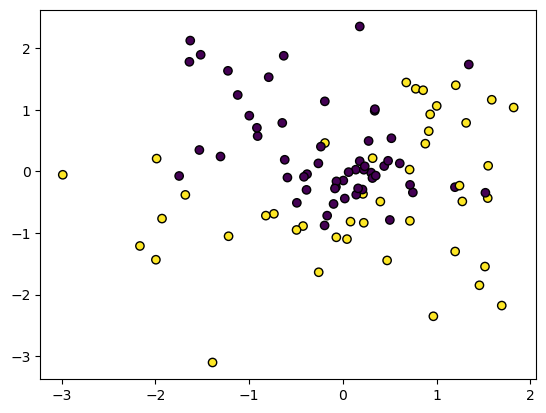

In [2]:
X_train, y_train, X_test, y_test = torch.load("data.pt")
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolors='k');
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Here are definitions of two different feature maps, the "simple" one and the "quadratic" one.

They define feature spaces in $\mathbb{R}^3$ and $\mathbb{R}^6$, respectively.

In [3]:
def features_simple(X) -> torch.Tensor:
    return torch.concat((torch.ones_like(X[:,:1]), X), -1)

def features_quadratic(X) -> torch.Tensor:
    interactions = X.prod(-1, keepdim=True)
    return torch.concat((torch.ones_like(X[:,:1]), 
                         X, X.pow(2), interactions), -1)

print("Dimension of Phi, `features_simple`:", features_simple(X_train).shape)
print("Dimension of Phi, `features_quadratic`:", features_quadratic(X_train).shape)

Dimension of Phi, `features_simple`: torch.Size([100, 3])
Dimension of Phi, `features_quadratic`: torch.Size([100, 6])


# TASK #1 (3 points): Define the model

The Bayesian logistic regression model we are working with has the form
$$\begin{align*}
\mathbf{w} &\sim \mathcal{N}(0, \sigma^2 \mathbf{I}) \\
\hat y_i &= \mathrm{Logistic}(\mathbf{w}^\top \phi(\mathbf{x}_i)) \\
y_i &\sim \mathrm{Bernoulli}(\hat y_i)
\end{align*}$$
where $i = 1,\dots, N$ and the Logistic function is defined
$$\begin{align*}
\mathrm{Logistic}(z) &= \frac{1}{1 + \exp\{-z\}}.
\end{align*}$$
It's implemented in pytorch as `torch.sigmoid`.

The first step is to define two functions, one to make predictions given a weight vector $\mathbf{w}$ and inputs $\Phi$, and one which computes the log joint probability

$$\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

I've done the first one for you.

In [4]:
def predict_probs_MAP(Phi, w):
    """
    Given a "design matrix" Phi, and a point estimate w, compute p(y = 1 | Phi, w)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w     : (D,) vector of weights

    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi, w)
    """
    y_hat = Phi @ w
    return torch.sigmoid(y_hat)

In [5]:
def log_joint(Phi, y, w, sigma=10)-> torch.Tensor:
    """
    Compute the joint probability of the data and the latent variables.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w     : (D,) vector of weights
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    log_joint : the log probability log p(y, w | Phi, sigma), a torch scalar
        
    """
    N, D = Phi.shape
    assert w.shape == (D,)
    assert y.shape == (N,)
    assert sigma > 0
    
    # Compute the log probability of the data given the weights and the 
    # standard deviation of the prior
    y_hat =predict_probs_MAP(Phi, w)
    log_likelihood = dist.Bernoulli(probs=y_hat).log_prob(y).sum()
    # Compute the log probability of the weights given the standard deviation
    # of the prior
    log_prior = dist.Normal(0, sigma**2).log_prob(w).sum()
    log_joint = log_likelihood + log_prior
    return log_joint
        

In [6]:
# (GRADING)

In [7]:
# (GRADING)

# TASK 2 (5 points): Implement MAP estimation

Now you need to write a function which performs MAP estimation, i.e. penalized maximum likelihood estimation.

This function should find the value $\mathbf{w}_{MAP}$ that maximizes the log joint, i.e.

$$\mathbf{w}_{MAP} = \mathrm{argmax}_{\mathbf{w}}\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

To do this, you should **use pytorch autograd tools**. This will involve defining an initial value of the weights, computing a scalar loss function, and calling `.backward()`, and then performing gradient-based optimization. Take a look at the demo notebooks from previous lectures for examples…!

* You **may feel free to use classes from `torch.optim`**. I would suggest the use of `torch.optim.SGD` or `torch.optim.Adagrad`.
* Regardless of how you do this, you will need to decide on a stopping criteria for your optimization routine.
* You will also need to decide on how to set the parameters (learning rate, momentum, anything else!) for your selected optimizer.

Also, **your code should work for ANY features!**. We will test this out on not just the "simple" and "quadratic" features above, but also on your own custom choice of features.

Maximum likelihood estimation loss function
$$l(\mathbf{y}, \mathbf{w};  \mathbf{\Phi}, \sigma^2) = -\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2)$$

In [8]:
def loss_fn(Phi, y, weights)-> torch.Tensor:
    return -log_joint(Phi, y, weights)

In [9]:
def find_MAP(Phi, y)-> (torch.Tensor, list):
    """
    Find the MAP estimate of the log_joint method.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones


    OUTPUT:
    w      : (D,) vector of optimized weights
    losses : list of losses at each iteration of the optimization algorithm.
             Should be a list of scalars, which can be plotted afterward to
             diagnose convergence.
    """

    weights = torch.zeros(Phi.shape[1]).requires_grad_(True)
    losses = []
    # chosen small learning rate and high momentum to get to convergence faster
    optimizer = torch.optim.SGD([weights], lr=0.001, momentum=0.7)                       
    for i in range(5000):            
        optimizer.zero_grad()
        loss = loss_fn(Phi, y, weights)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        #when losses has at least 10 elements, check if the last 10 elements are within 0.001 of each other, then stop
        if len(losses) >= 10:
            differences = torch.diff(torch.tensor(losses[-10:]))
            abs_diff = torch.abs(differences)
            if torch.max(abs_diff) <= 0.001:
                break
    return weights.detach(), losses

### The following two cells call `find_MAP` to compute $\mathbf{w}$ for both choices of features.

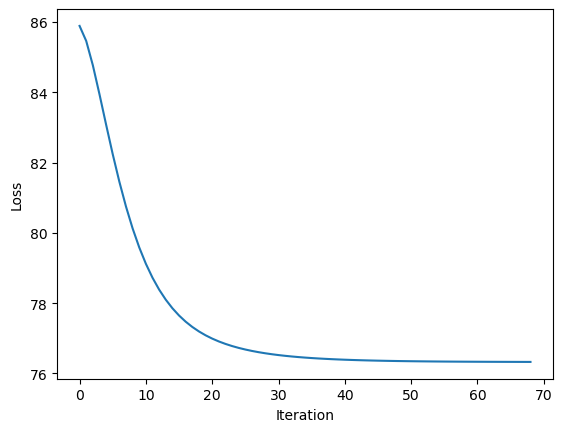

In [10]:
w_MAP_simple, losses = find_MAP(features_simple(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

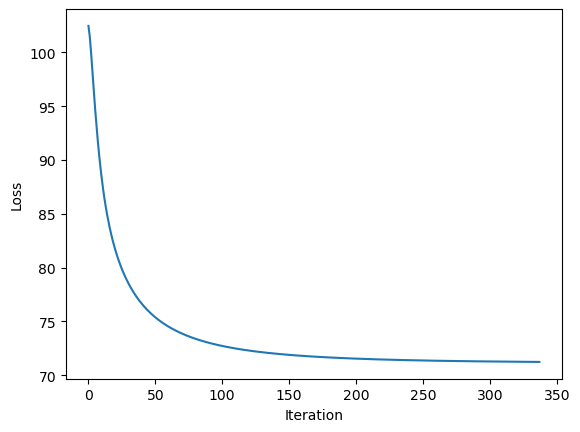

In [11]:
w_MAP_quad, losses = find_MAP(features_quadratic(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [12]:
# (GRADING)

In [13]:
# (GRADING)

## Visualization: The following code visualizes the classifier result

It plots the probability of being one class or the other using a color contour plot.

The decision boundary is a dashed black line.

In [14]:
def plot_boundary(X, y, pred):
    h = 0.2
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = pred(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.8, levels=np.linspace(0, 1, 8))
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    
    plt.contour(xx, yy, Z, levels=(0.5,), linestyles='dashed');
    
    # Plot the testing points
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

Simple features: training accuracy = 0.68, test accuracy = 0.68


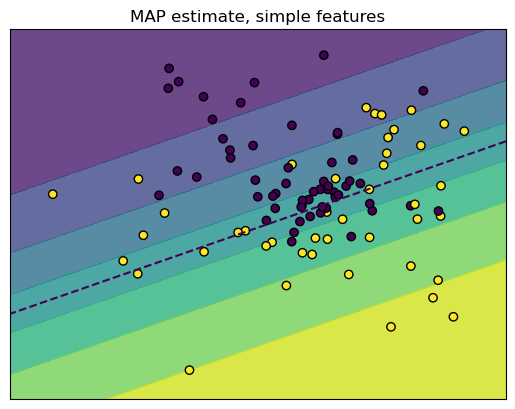

In [15]:
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))
plt.title("MAP estimate, simple features")
train_accuracy = (predict_probs_MAP(features_simple(X_train), w_MAP_simple).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_simple(X_test), w_MAP_simple).round() == y_test).float().mean()
print("Simple features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

Polynomial features: training accuracy = 0.86, test accuracy = 0.92


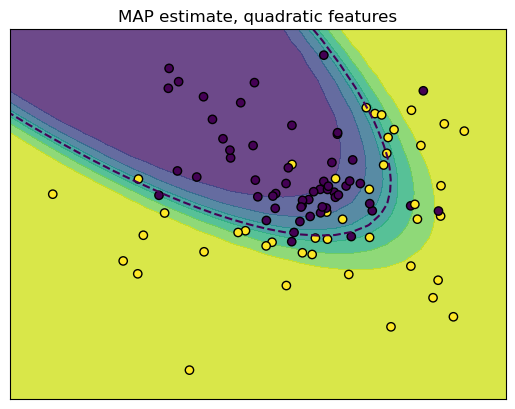

In [16]:
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))
plt.title("MAP estimate, quadratic features")
train_accuracy = (predict_probs_MAP(features_quadratic(X_train), w_MAP_quad).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_quadratic(X_test), w_MAP_quad).round() == y_test).float().mean()
print("Polynomial features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

# TASK #3 (5 points): Laplace approximation

In the next section, you will fit an approximate posterior over the weights by using the Laplace approximation around the mode $\mathbf{w}_{MAP}$ of the distribution you found above.

This requires completing two functions:

1. `compute_laplace_Cov` takes the data and the MAP estimate, and outputs a covariance matrix defined as the negative inverse Hessian of the log target density. (See the week 4 lecture slides for details on how to compute this!)
2. `predict_bayes` makes predictions on new data points, by approximating $\int p(y | x, w)p(w | \mathcal{D})dw$ when using a Gaussian approximation to $p(w | \mathcal{D})$. In the week 4 lecture slides we discussed three different ways of computing this — it is up to you to decide what method you would prefer, and implement it.

In [17]:
def calculate_hassian(D, N, Phi, y_hat, prior_sigma_inverse):
    
    hessian = torch.zeros(D, D)
    for i in range(N):
        hessian += (y_hat[i]*(1-y_hat[i])*torch.outer(Phi[i,:],Phi[i,:].T))
    hessian += prior_sigma_inverse
    return hessian  

In [18]:
def compute_laplace_Cov(Phi, y, w_MAP, prior_std=10):
    """
    Compute the Laplace approximation of the posterior covariance 
    in a logistic regression setting.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sig
            ma=10 for purposes of this exercise

    OUTPUT:
    Cov : (D, D) posterior covariance matrix estimate defined by the Laplace 
          approximation
    """
    cov_matrix = torch.zeros(Phi.shape[1], Phi.shape[1])
    N, D = Phi.shape
    
    prior_sigma = torch.eye(D)*prior_std**2
    prior_sigma_inverse = torch.inverse(prior_sigma)
    y_hat = predict_probs_MAP(Phi, w_MAP)
    
    hessian = calculate_hassian(D, N, Phi, y_hat, prior_sigma_inverse)
    cov_matrix = torch.inverse(hessian)
    
    #assert it's positive semi definite
    eigenvalues = torch.linalg.eigvalsh(cov_matrix)
    assert torch.all(eigenvalues >= 0), "The matrix is not positive semi-definite"
    
    return cov_matrix

In [19]:
def predict_bayes(Phi, w_MAP, Cov):
    """
    Make predictions on new data points using an approximate posterior 
    w ~ MultivariateNormal(w_MAP, Cov)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi)
    """
    N, D = Phi.shape
    assert w_MAP.shape == (D,)
    assert Cov.shape == (D, D)
    
    mu_a = Phi @ w_MAP
    #take diagonal of covariance matrix to get variance of individual predictions 
    sigma_squared_diag = torch.diag(Phi @ Cov @ Phi.T)
    
    #predict probability of y=1
    y_hat = torch.sigmoid(mu_a/(torch.sqrt(1+(torch.pi*sigma_squared_diag)/8)))
    assert y_hat.shape == (N,)
    
    return y_hat

### The following cells call your functions above to compute the Laplace approximation and visualize the posterior predictive distribution.

In [20]:
Cov_simple = compute_laplace_Cov(features_simple(X_train), y_train, w_MAP_simple)

C:\Users\alina\AppData\Local\Temp\ipykernel_16836\1340947125.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3618.)
  hessian += (y_hat[i]*(1-y_hat[i])*torch.outer(Phi[i,:],Phi[i,:].T))


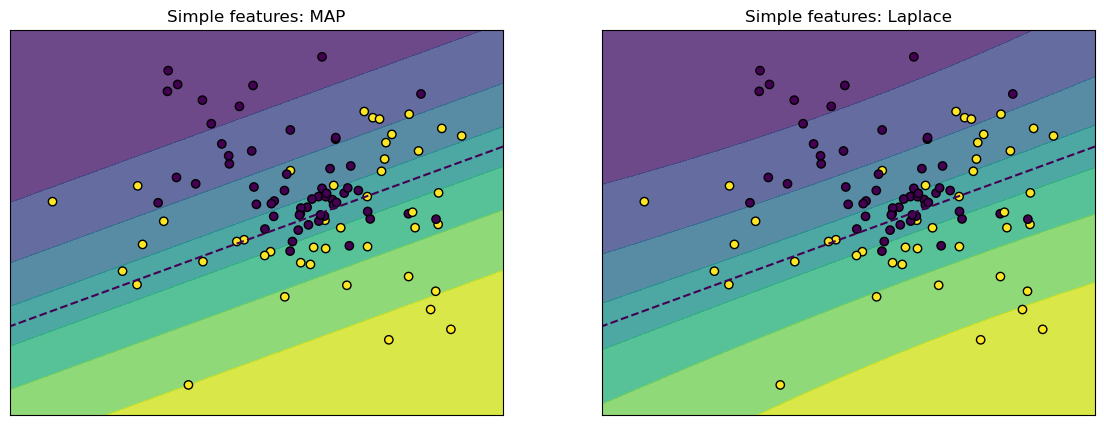

In [21]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Simple features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))

plt.subplot(122)
plt.title("Simple features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_simple(X), w_MAP_simple, Cov_simple))

In [22]:
Cov_quad = compute_laplace_Cov(features_quadratic(X_train), y_train, w_MAP_quad)

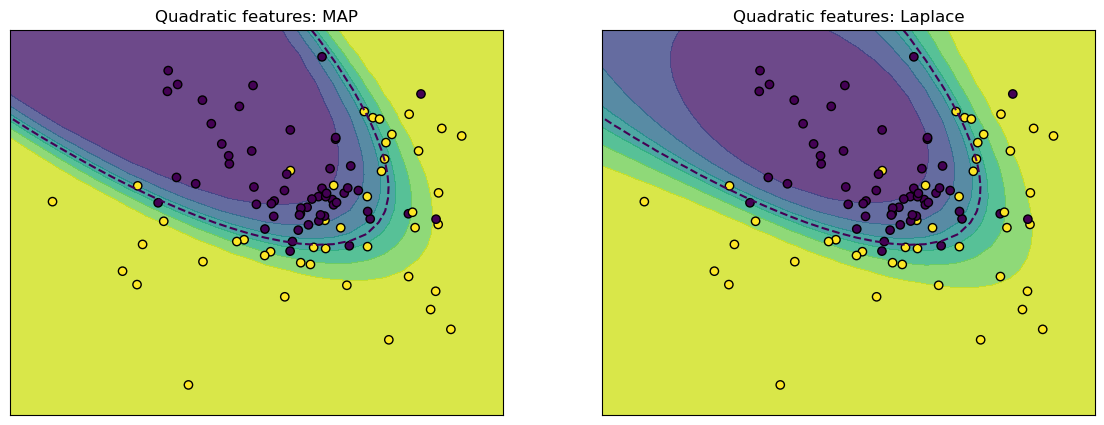

In [23]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Quadratic features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))

plt.subplot(122)
plt.title("Quadratic features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_quadratic(X), w_MAP_quad, Cov_quad))

In [24]:
# (GRADING)

In [25]:
# (GRADING)

In [26]:
# (GRADING)

# TASK #4 (2 points): Model comparison

You can compute the marginal likelihood approximation defined by the Laplace approximation.

This estimate of the evidence can be used, even just looking at the training data, to help decide which of the two feature maps is more appropriate and better fits the data.

This can help guard against potential overfitting if using features that are "too complex".

In [27]:
def compute_laplace_log_evidence(Phi, y, w_MAP, Cov):
    """
    This computes the Laplace approximation to the marginal likelihood,
    as defined in the Week 5 lectures.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    log_evidence : scalar value estimating `log p(y | Phi)`
    """
    N, D = Phi.shape
    #compute log evidence by suming log joint and log marginal
    log_evidence = log_joint(Phi, y, w_MAP) + D/2*torch.log(torch.Tensor([2*torch.pi])) + 0.5*torch.log(torch.det(torch.inverse(Cov)))
        
    return log_evidence

In [28]:
print("Model evidence estimate (simple features):",
      compute_laplace_log_evidence(features_simple(X_train), y_train, w_MAP_simple, Cov_simple).item())

print("Model evidence estimate (polynomial features):",
      compute_laplace_log_evidence(features_quadratic(X_train), y_train, w_MAP_quad, Cov_quad).item())

Model evidence estimate (simple features): -69.28487396240234
Model evidence estimate (polynomial features): -59.88301086425781


In [29]:
# (GRADING)

# TASK #5 (2 points + 4 points): Define your own feature space

Your next task is to define your own, custom feature space! This can be practically any deterministic function from $\mathbb{R}^2$ to $\mathbb{R}^D$, and you even get to pick the dimensionality $D$.

In the following cells, you first define your feature space, and then we estimate the posterior using your code above. We report training accuracy, test accuracy, and model evidence, as well as plot the decision boundaries.

Feel free to get quite creative here! However, you will be asked to defend your choice of feature space in the free-answer section at the bottom.

**Make sure when you submit, you include whatever you consider the "best" possible choice!**

In [30]:
def features_student(X):
    """
    Compute your own, custom set of features!
    
    INPUT:
    X      : (N, 2) tensor of raw input data
    
    OUTPUT:
    Phi    : (N, D) tensor of transformed inputs
    """
    N, D_original = X.shape
    # polynomial up to X^2
    interactions = X.prod(-1, keepdim=True)
    Phi = torch.cat((torch.ones_like(X[:,:1]), X, X.pow(2), interactions), -1)
    
    # polynomial up to X^3
    #Phi = torch.cat((torch.ones_like(X[:,:1]), X, X.pow(2), X.pow(3) ), -1)
    
    # polynomial up to X^7
    #Phi = torch.cat((torch.ones_like(X[:,:1]), X, X.pow(2), X.pow(3),X.pow(4),X.pow(5),X.pow(6), X.pow(7), interactions ), -1)
    
    # cos and sin features
    #Phi = torch.cat((torch.ones_like(X[:,:1]), X, torch.cos(X), torch.sin(X)),  -1)
    
    
    #random features calculation
    #used to calculate 20 new random features
    # D_new = 20
    # A = torch.randn((D_new, D_original))
    # b = torch.rand(D_new) * 2 * torch.pi
    # Ax_plus_b = torch.matmul(A, X.T) + b.unsqueeze(1)
    # cos_features = torch.cos(Ax_plus_b).T
    # sin_features = torch.sin(Ax_plus_b).T
    # Phi = torch.cat((torch.ones_like(X[:,:1]), X, cos_features ), -1)
    
    #random features with sin and the interaction term
    # Phi = torch.cat((torch.ones_like(X[:,:1]), X, cos_features, sin_features, cos_features*sin_features ), -1)
    
    return Phi
    

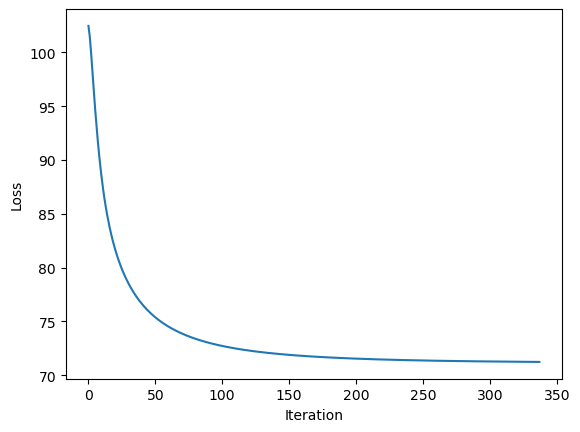

In [31]:
w_MAP_student, losses = find_MAP(features_student(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [32]:
train_accuracy = (predict_probs_MAP(features_student(X_train), w_MAP_student).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_student(X_test), w_MAP_student).round() == y_test).float().mean()
print("YOUR features! Training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

YOUR features! Training accuracy = 0.86, test accuracy = 0.92


In [33]:
Cov_student = compute_laplace_Cov(features_student(X_train), y_train, w_MAP_student)

print("YOUR features! Model evidence estimate:",
      compute_laplace_log_evidence(features_student(X_train), y_train, w_MAP_student, Cov_student).item())

YOUR features! Model evidence estimate: -59.88301086425781


In [34]:
w_MAP_student

tensor([-1.9028,  0.9123, -1.8254,  1.1174,  0.8531,  1.6203])

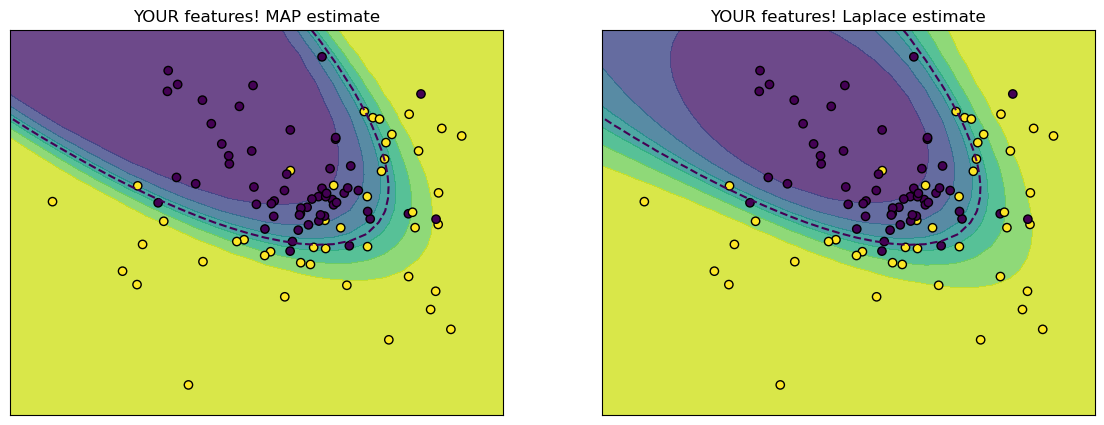

In [35]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("YOUR features! MAP estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_student(X), w_MAP_student))

plt.subplot(122)
plt.title("YOUR features! Laplace estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_student(X), w_MAP_student, Cov_student))

# Please answer the following short questions:

1. *[Feature selection]* How did you choose your features? Name at least two ways of comparing whether one set of features is "better" than another. Would these methods generally yield the same "ranking" of different features? Why or why not?
2. *[Overfitting]* Is "overfitting" possible in this setting? Did you experience it? If so, how would you detect it? Does using the Laplace approximation "help" with overfitting, or does it not make a difference? Justify your answer.

YOUR ANSWER HERE

# Different Models performance table

Simple Model:

    1. Simple features: training accuracy = 0.68, test accuracy = 0.68
    2. Model evidence estimate (simple features): -69.28487396240234

Quadratic polynomial model:

    1.Polynomial features: training accuracy = 0.86, test accuracy = 0.92
    2.Model evidence estimate (polynomial features): -59.88301086425781

Cubic polynomial model:

    1. Training accuracy = 0.87, test accuracy = 0.82
    2. Model evidence estimate: -58.76191711425781
    
SIN + COS model:

    1. Training accuracy = 0.85, test accuracy = 0.82
    2. Model evidence estimate: -67.10564422607422

Random features with Cos:

    1.Training accuracy = 0.47, test accuracy = 0.72
    2. Model evidence estimate: -213.0966796875

Random features with cos and sin plus interaction:

    1.Training accuracy = 0.35, test accuracy = 0.76
    2.Model evidence estimate: -330.04693603515625

Polynomial up to 7

    1. Training accuracy = 0.92, test accuracy = 0.86
    2. -98.72757720947266
    

1. *[Feature selection]* 

I have tried several different features,(see the results for model evidence, training and test accuracy for the different features in the table above). When choosing the best features the two important metrics in this instance are test accuracy and model evidence estimate. The best model would have highest model evidence as this metric estimates the likelihood(probability) of the data given the model with the parameters marginalised out. There are 2 models in this list with the highest evidence: the quadratic polynomial(apprx -59.88) and the cubic polynomial(approx -58.76). In these estimations the log is taken to avoid numerical instability so the best model evidence is the one closest to zero. The second estimate of a good model is test accuracy; this is a more direct estimate as this evaluates how the model performs on the test data(new data) rather than the training one. In this particular case quadratic polynomial has the highest test accuracy(0.92), correctly predicting 92% of the data. Given these two criteria quadratic polynomial is the best model here.


2. *[Overfitting]*

It is possible to overfit in this setting. For example, from the table, when estimating a polynomial of up to 7, training accuracy increases to 0.92 compared to the training accuracy of the quadratic, which is 0.86. However, the test accuracy for the polynomial of 7 is lower (0.86) compared to that of the quadratic (0.92). Comparing training accuracy to test accuracy can indicate if the model is overfitting; a model that overfits will have much higher training accuracy with the data it was trained on rather than with the new test data. All other models did not overfit significantly (although the boundary became more and more specific to the training data) as they have significantly lower model evidence and lower test accuracy compared to the proposed 'best' model, even though they are a lot more complex than the quadratic. The Laplace approximation captures the mode of the posterior quite well as the boundaries look very similar across all models with MAP and Laplace; however, the shape is slightly distorted with the Laplace approximation. In this case, Laplace does not help with overfitting because it does not control the complexity of the model; this is defined by the features.

#### Ignore the following cells. They are used by the grading system.

In [36]:
# (GRADING)

In [37]:
# (GRADING)